In [1]:
%matplotlib inline

# Extending Sequence Prediction Using Character Level Recurrent Networks

*The code in this notebook may be unnecessarily complicated, due to trial and error*

We extend the approach outlined in `char_rnn_one_file_code_gen.ipynb` to improve efficiency and to accomodate other recurrent cells. Notably:

* Training will use multiple files, instead of a single file
* Validation sets will be introduced to avoid overfitting on our training data
* We will have our model utilize mini-batches to speed up training

Our outlined task is still the same.

**Given a sequence of characters, predict the next likely character in the sequence.**

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
from json import load
from math import floor
from time import time

## Preparing the Data

We will be training on a set of 180 preprocessed Python files (and validating on a set of 20 other files) arbitrarily sampled from [GitHub BigQuery Python Extracts](https://bigquery.cloud.google.com/table/fh-bigquery:github_extracts.contents_py_201802snap?pli=1).

We limit the characters that our neural network can produce to a subset of standard ASCII.
* `ORD 2*, 3*, 9, 10, 32-126`
  * `ORD 0` for padding (special, used in batch_size > 1 with variable length sequences)
  * `ORD 2` for start of text (special, never predicted)
  * `ORD 3` for end of text (special, prediction ends)
  * `ORD 9` horizontal tab "\t"
  * `ORD 10` NL line feed, new line "\n"
  * `ORD 32-126` Space, Punctuation, Digits, English Letters

NOTE: The full dataset contains files written using non standard characters. For the models in this notebook, we ensure that all Python files within our dataset are composed only of ASCII characters that we accept.

In [3]:
# Possible Characters for neural network
VALID_UNICODE_IDS = (0, 2, 3, 9, 10) + tuple(range(32, 127))
for uid in VALID_UNICODE_IDS:
    if uid <= 32:
        print("{}: {}".format(uid, repr(chr(uid))))
        continue
    print(chr(uid), end="")
print()

# Special Characters
PAD = chr(0)
FILE_START = chr(2)
FILE_END = chr(3)

CHARACTERS = set(chr(id) for id in VALID_UNICODE_IDS)
INT2CHAR = dict(enumerate(CHARACTERS))
CHAR2INT = {char: idx for idx, char in INT2CHAR.items()}

with open("./data/train.json", "r") as f:
    training_data = load(f)
with open("./data/validate.json", "r") as f:
    validation_data = load(f)

print("~" * 25)
print("Num Training Files: {}".format(len(training_data)))
print("Num Validation Files: {}".format(len(validation_data)))

# SANITY_CHECK, MEMORIZE ONE FILE
with open("./data/test.py", "r") as f:
    text = f.read()
training_data = ((FILE_START, ) + tuple(text) + (FILE_END,),)
print("SANITY Training Files: {}".format(len(training_data)))

0: '\x00'
2: '\x02'
3: '\x03'
9: '\t'
10: '\n'
32: ' '
!"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~
~~~~~~~~~~~~~~~~~~~~~~~~~
Num Training Files: 180
Num Validation Files: 20
SANITY Training Files: 1


Let's randomly take a look at what is contained within our training data.

In [4]:
train_sample = random.sample(training_data, 1)[0]
print("".join(train_sample))

"""Predict Test"""
import sys
from os import getcwd

def main():
    sys.stdout.write(getcwd())
    for i in range(0, 10):
        print("{} : Boop".format(i), i)
    return False

if __name__ == "__main__":
    main()



## Batching Sliding Window Algorithm

Extending from the previously created sliding window algorithm:

* Given some iterable, we want a generator that yields X, Y pairs for evaluation.
* We want a sequence of a given context length as X, and the next character as Y.

We want our sliding window algorithm to yield these pairs in batches, for more efficient computation. Iterable is no longer a single file, but an iterator over multiple files.

In [5]:
def batch_sliding_window_generator(iterable_files, batch_size, max_window_size=None, output_seq=False, gen_forever=True):
    """Sliding window generator for batching files of ASCII characters
    """
    while True:
        data_pairs = []

        for iterable in iterable_files:
            if max_window_size is None:
                window_size = len(iterable)
            else:
                window_size = max_window_size

            # edge case inbetween files
            existing_window_sizes = [len(x) for x, _ in data_pairs]
            if existing_window_sizes and not all(size == window_size for size in existing_window_sizes):
                window_size = min(existing_window_sizes)

            for window_idx in range(1, len(iterable)):
                x = iterable[:window_idx]
                if len(x) > window_size:
                    x = x[-window_size:]
                elif len(x) < window_size:
                    x = (PAD,) * (window_size - len(x)) + tuple(x)
                y = iterable[window_idx]
                if output_seq:
                    y = (x + (y,))[-window_size:]
                data_pairs.append((x, y))

            random.shuffle(data_pairs)
            while len(data_pairs) >= batch_size:
                to_yield = data_pairs[:batch_size]
                data_pairs = data_pairs[batch_size:]
                
                # order by sequence lengths
                sorted_to_yield = sorted(to_yield, key=lambda kv: kv[0].count(PAD))
                yield sorted_to_yield, np.array([len(x) - x.count(PAD) for x, _ in sorted_to_yield])

        # To ensure all batches have the same size and no data is left unused, re-sample last file
        if data_pairs:
            assert len(data_pairs) < batch_size
            cleanup_data_pairs = []
            for window_idx in range(1, len(iterable)):
                x = iterable[:window_idx]
                if len(x) > window_size:
                    x = x[-window_size:]
                elif len(x) < window_size:
                    x = (PAD,) * (window_size - len(x)) + tuple(x)
                y = iterable[window_idx]
                if output_seq:
                    y = (x + (y,))[-window_size:]
                cleanup_data_pairs.append((x, y))
            cleanup_data_pairs = random.sample(cleanup_data_pairs, batch_size - len(data_pairs))
            data_pairs.extend(cleanup_data_pairs)
            # development, check for correctness
            assert len(data_pairs) == batch_size
            data_pairs.sort(key=lambda kv: kv[0].count(PAD))
            yield data_pairs, np.array([len(x) - x.count(PAD) for x, _ in data_pairs])
                
        if not gen_forever:
            break

Here are the first 3 generator outputs, given a batch size of 2 and a maximum window size of 10.

In [6]:
batch_size = 1
max_window_size = 15

gen = batch_sliding_window_generator(training_data, batch_size, max_window_size)
for i in range(3):
    batch, _ = next(gen)
    print("Batch {}".format(i))
    print(*batch, sep="\n")
    print("~"*25)

print("Padding Example")
searching = True
while searching:
    batch, _ = next(gen)
    for x, y in batch:
        if PAD in x:
            searching = False
            break
print((x, y,))

Batch 0
(('a', 'i', 'n', '(', ')', ':', '\n', ' ', ' ', ' ', ' ', 's', 'y', 's', '.'), 's')
~~~~~~~~~~~~~~~~~~~~~~~~~
Batch 1
(('e', 't', 'c', 'w', 'd', '\n', '\n', 'd', 'e', 'f', ' ', 'm', 'a', 'i', 'n'), '(')
~~~~~~~~~~~~~~~~~~~~~~~~~
Batch 2
(('i', 'n', '_', '_', '"', ':', '\n', ' ', ' ', ' ', ' ', 'm', 'a', 'i', 'n'), '(')
~~~~~~~~~~~~~~~~~~~~~~~~~
Padding Example
(('\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x02', '"', '"', '"', 'P'), 'r')


We can see how changing the `batch_size` and `max_window_size` parameters of the generator influence the values we use to train our neural network.

Setting `batch_size=1` and `max_window_size=None` is most computationally expensive option, which has equivalent functionality to the batching algorithm defined in `char_rnn_one_file_code_gen.ipynb`.

In [7]:
# ensure that the dynamic batch window size logic works for arbitrary sequence lengths

# This takes some time to run. Set this to 0 if you understand the batching generator functionality
# check_batch_size = 0
check_batch_size = 1
# check_batch_size = 100

# If set to None, window sizes will default to the number of characters in the file
check_window_size = 10
# check_window_size = None

if check_batch_size:
    print("Checking batch_size={}, max_window_size={}:".format(check_batch_size, check_window_size))
    gen = batch_sliding_window_generator(
        training_data, check_batch_size, max_window_size=check_window_size, gen_forever=False)

    batch_windows = {}
    all_item_seqs_lens = {}
    for batch, item_seq_lens in gen:
        x, _ = batch[0]
        batch_window_size = len(x)
        assert all(batch_window_size == len(x) for x, _ in batch)
        batch_windows[batch_window_size] = batch_windows.get(batch_window_size, 0) + 1
        for item_seq_len in item_seq_lens:
            all_item_seqs_lens[item_seq_len] = all_item_seqs_lens.get(item_seq_len, 0) + 1
    print(" • {} number of batches".format(sum(batch_windows.values())))
    for window_size, num_batches in sorted(batch_windows.items(), key=lambda kv: kv[1]):
        print("   • {} batches have window size {}".format(num_batches, window_size))
    print(" • {} number of examples".format(sum(all_item_seqs_lens.values())))
    for seq_len_size, num_examples in sorted(all_item_seqs_lens.items(), key=lambda kv: kv[0]):
        print("   • {} examples have seq len {}".format(num_examples, seq_len_size))

    gen = batch_sliding_window_generator(
        training_data, check_batch_size, max_window_size=check_window_size, gen_forever=False)
    for batch, seqlens in gen:
        for idx, xy in enumerate([e for e in batch if PAD in e[0] or FILE_END in e[1]]):
            x, y = xy
            print(seqlens[idx], x, y)

Checking batch_size=1, max_window_size=10:
 • 220 number of batches
   • 220 batches have window size 10
 • 220 number of examples
   • 1 examples have seq len 1
   • 1 examples have seq len 2
   • 1 examples have seq len 3
   • 1 examples have seq len 4
   • 1 examples have seq len 5
   • 1 examples have seq len 6
   • 1 examples have seq len 7
   • 1 examples have seq len 8
   • 1 examples have seq len 9
   • 211 examples have seq len 10
9 ('\x00', '\x02', '"', '"', '"', 'P', 'r', 'e', 'd', 'i') c
2 ('\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x02', '"') "
1 ('\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x02') "
4 ('\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x02', '"', '"', '"') P
5 ('\x00', '\x00', '\x00', '\x00', '\x00', '\x02', '"', '"', '"', 'P') r
10 (' ', ' ', ' ', 'm', 'a', 'i', 'n', '(', ')', '\n') 
3 ('\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x02', '"', '"') "
6 ('\x00', '\x00', '\x00', '\x00', '\x02', 

An additional tensor containing the original lengths of all the padded sequences is also outputted for each batch. It is sorted by length in decreasing order, as per the [pad_packed_sequence](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence) documentation.

In [8]:
check_batch_size = 10
check_window_size = None
gen = batch_sliding_window_generator(
    training_data, check_batch_size, max_window_size=check_window_size, gen_forever=False)

batch, x_seqs_len = next(gen)
x_seqs, _ = zip(*batch)

for idx, x_seq in enumerate(x_seqs):
    x_seq_len = x_seqs_len[idx].item()
    print("X_Sequence {} has length {} ({} pad chars)".format(idx, x_seq_len, len(x_seq) - x_seq_len))

num_pads = len(x_seqs[0]) - x_seqs_len[0].item()
# print(x_seqs[0][num_pads:][:3])


X_Sequence 0 has length 212 (9 pad chars)
X_Sequence 1 has length 104 (117 pad chars)
X_Sequence 2 has length 89 (132 pad chars)
X_Sequence 3 has length 76 (145 pad chars)
X_Sequence 4 has length 62 (159 pad chars)
X_Sequence 5 has length 49 (172 pad chars)
X_Sequence 6 has length 46 (175 pad chars)
X_Sequence 7 has length 44 (177 pad chars)
X_Sequence 8 has length 42 (179 pad chars)
X_Sequence 9 has length 21 (200 pad chars)


### Utilize CUDA & GPU
Training neural networks can be slow. It would be useful to utilize GPUs if we have them available to us.

In [9]:
device = torch.device("cpu")
HAS_GPU = False
if torch.cuda.is_available():
    HAS_GPU = True
    print("CUDA is available")
    print(" • Number of CUDA devices: {}".format(torch.cuda.device_count()))
    device = torch.device("cuda")
    print(" • Current Device Name: {}".format(torch.cuda.get_device_name(device)))
    print(" • Device CUDA Capability: {}".format(torch.cuda.get_device_capability(device)))

else:
    print("CUDA is not available.")

# force GPU off.
HAS_GPU = False
device = torch.device("cpu")

CUDA is available
 • Number of CUDA devices: 1
 • Current Device Name: TITAN Xp
 • Device CUDA Capability: (6, 1)


## Batch Characters to Tensors

Our batch of inputs and outputs must be converted into Tensors for training.

We follow the default matrix convention used by the PyTorch comunity.

> Tensor’s data will be of size `T x B x *`, where `T` is the length of the longest sequence and `B` is the batch size. 

To make a batch training example, we join a bunch our sequences of one-hot characters into a matrix of size `(window_size, batch_size, num_chars)`.

In [10]:
def charseq_to_tensor(char_seq, num_chars=len(CHARACTERS)):
    seq_size = len(char_seq)
    seq_tensor = torch.zeros(seq_size, 1, num_chars, device=device)
    for seq_idx, char in enumerate(char_seq):
        seq_tensor[seq_idx][0][CHAR2INT[char]] = 1
    return seq_tensor

def batch_xy_to_tensor_xy(batch, num_chars=len(CHARACTERS)):
    batch_size = len(batch)
    window_size = max([len(x) for x, _ in batch])
    assert all(len(x) == window_size for x, _ in batch)
    
    x_tensor = torch.zeros(window_size, batch_size, num_chars, device=device)
    y_tensor = torch.zeros(1, batch_size, num_chars, device=device)

    for batch_elm_idx, xy_pair in enumerate(batch):
        x_char_seq, y_char = xy_pair
        for seq_idx, x_char in enumerate(x_char_seq):
            x_tensor[seq_idx][batch_elm_idx][CHAR2INT[x_char]] = 1
        y_tensor[0][batch_elm_idx][CHAR2INT[y_char]] = 1
    return x_tensor, y_tensor

def batch_xy_to_tensor_xyseq(batch, num_chars=len(CHARACTERS)):
    batch_size = len(batch)
    window_size = max([len(x) for x, _ in batch])
    assert all(len(x) == window_size for x, _ in batch)
    
    x_tensor = torch.zeros(window_size, batch_size, num_chars, device=device)
    y_tensor = torch.zeros(window_size, batch_size, num_chars, device=device)

    for batch_elm_idx, xy_pair in enumerate(batch):
        x_char_seq, y_char_seq = xy_pair
        for seq_idx, x_char in enumerate(x_char_seq):
            x_tensor[seq_idx][batch_elm_idx][CHAR2INT[x_char]] = 1
            y_tensor[seq_idx][batch_elm_idx][CHAR2INT[y_char_seq[seq_idx]]] = 1
    return x_tensor, y_tensor

The tensor inputs and outputs for the generator function we defined earlier are shown here.

In [11]:
gen = batch_sliding_window_generator(training_data, batch_size, max_window_size)

batch, _ = next(gen)
x = [item[0] for item in batch]
y = [repr(item[1]) for item in batch]
x_tensor, y_tensor = batch_xy_to_tensor_xy(batch)

print("batch_size: {}, max_window_size: {}".format(batch_size, max_window_size))
print("~" * 25)
print(*x, sep="\n")
print(x_tensor.size())
print(*y, sep="\n")
print(y_tensor.size())

batch_size: 1, max_window_size: 15
~~~~~~~~~~~~~~~~~~~~~~~~~
(' ', ' ', ' ', ' ', 's', 'y', 's', '.', 's', 't', 'd', 'o', 'u', 't', '.')
torch.Size([15, 1, 100])
'w'
torch.Size([1, 1, 100])


## Creating the Network

We are going to create our recurrent neural network. Rather than using our own pure recurrent neural network defined in the last notebook, we will be using the [recurrent layers](https://pytorch.org/docs/stable/nn.html#recurrent-layers) provided by PyTorch.
* **RNN**: [Recurrent Neural Network](https://pytorch.org/docs/stable/nn.html#rnn)
* **GRU**: [Gated Recurrent Unit](https://pytorch.org/docs/stable/nn.html#gru)
* **LSTM**: [Long Short-Term Memory](https://pytorch.org/docs/stable/nn.html#lstm)

There are some subtleties in the forward pass function, as we want to mask away the `PAD` characters so they do not influence our model results.

Our model is composed of the following:
0. Recurrent Layer (RNN/GRU/LSTM)
1. Linear Layer
2. Softmax Activation

In [12]:
class CharRNN(nn.Module):
    def __init__(self, input_size, output_size, batch_size,
                 hidden_size=128, recurrent_layer_type="RNN", recurrent_layers=1, recurrent_dropout=0):
        super(CharRNN, self).__init__()

        self.hidden_size = hidden_size
        self.recurrent_num_layers = recurrent_layers
        self.batch_size = batch_size

        rn_kwargs = {
            "input_size": input_size,
            "hidden_size": hidden_size,
            "num_layers": recurrent_layers,
            "dropout": recurrent_dropout,
        }

        self.rn_type = recurrent_layer_type        
        if recurrent_layer_type == "RNN":
            self.input_to_rn = nn.RNN(**rn_kwargs)
        elif recurrent_layer_type == "LSTM":
            self.input_to_rn = nn.LSTM(**rn_kwargs)
        elif recurrent_layer_type == "GRU":
            self.input_to_rn = nn.GRU(**rn_kwargs)
        else:
            raise "Invalid recurrent layer type: {}".format(recurrent_layer_type)

        
        self.rn_to_output = nn.Linear(hidden_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, batched_input_chars, hidden):
        # pack > recurrent network > unpack (packing not necessary for this task?)
        # packed_input_seqs = nn.utils.rnn.pack_padded_sequence(input_seqs, input_seqs_len)
        rn_outs, next_hidden = self.input_to_rn(batched_input_chars, hidden)
        # unpacked_rn_outs, _ = nn.utils.rnn.pad_packed_sequence(rn_outs, padding_value=CHAR2INT[PAD])

        if self.rn_type == "LSTM":
            combined = torch.cat((rn_outs, next_hidden[0]), dim=2)
        else:
            combined = torch.cat((rn_outs, next_hidden), dim=2)
        # send rn output through dense linear layer with softmax activation
        pre_activated_output = self.rn_to_output(combined)
        predicted_output = self.softmax(pre_activated_output)

        return predicted_output, next_hidden
    
    def init_hidden(self):
        if self.rn_type == "LSTM":
            return (
                torch.zeros(self.recurrent_num_layers, self.batch_size, self.hidden_size, device=device),
                torch.zeros(self.recurrent_num_layers, self.batch_size, self.hidden_size, device=device)
            )
        return torch.zeros(self.recurrent_num_layers, self.batch_size, self.hidden_size, device=device)

Initialize this network with values appropriate for the character prediction task.

In [13]:
n_chars = len(CHARACTERS)
batch_size = 4

char_rnn = CharRNN(n_chars, n_chars, batch_size, recurrent_layer_type="RNN")
if HAS_GPU:
    char_rnn.cuda(device)

Before each batch, we zero out the RNN hidden state.

In [14]:
max_window_size = 20
gen = batch_sliding_window_generator(training_data, batch_size, max_window_size, gen_forever=False)
batch, _ = next(gen)

x_seq_tensor, y_tensor = batch_xy_to_tensor_xy(batch)
x_char_tensor = x_seq_tensor.narrow(0, 0, 1)

hidden = char_rnn.init_hidden()
output, next_hidden = char_rnn(x_char_tensor, hidden)
print("Output:", output.size())


Output: torch.Size([1, 4, 100])


## Preparing to Train our Model
We will create a helper function to convert the network predicted output back to a human readable character.

In [15]:
def readable_from_output(output):
    """Convert network output predictions back to readable values."""
    top_n, top_i = output.topk(1)
    batch_elems, _ = top_i[0].size()
    batch_chars = []
    for batch_elm_idx in range(batch_elems):
        char_index = top_i[0][batch_elm_idx].item()
        batch_char = INT2CHAR[char_index], char_index
        batch_chars.append(batch_char)
    return tuple(batch_chars)

# What was predicted for each batch element?
for batch_elem_idx, readable in enumerate(readable_from_output(output)):
    print("Batch element {}: {}".format(batch_elem_idx, readable))
for batch_elem_idx, readable in enumerate(readable_from_output(y_tensor)):
    print(readable)

Batch element 0: ('x', 48)
Batch element 1: ('l', 66)
Batch element 2: ('l', 66)
Batch element 3: ('\x02', 41)
('_', 64)
('o', 96)
('B', 67)
('P', 26)


Show the network some examples, have it make predictions, and then inform the network when the predictions are correct.
We have a classification problem, so Negative Log Likelihood loss is appropriate.

For classifing input into `C` number of classes, the following loss functions are useful:

* **Cross Entropy Loss**: [CrossEntropyLoss docs](https://pytorch.org/docs/stable/nn.html#crossentropyloss)
* **Negative Log Likelihood Loss**: [NLLLoss docs](https://pytorch.org/docs/stable/nn.html#nllloss)


In [16]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()

Each training loop will:

0. Create input and target tensors
0. Initialize a zerored hidden state
0. Read each letter in and keep the hidden state for the next letter
0. Compare the final output to the target
0. Back-propagate
0. Return the output and loss

In [17]:
def train(true_output_tensor, char_sequence_tensor, learning_rate = 0.005):
    hidden = char_rnn.init_hidden()
    
    # Sets gradients of all model parameters to zero
    char_rnn.zero_grad()
    loss = 0

    hidden = char_rnn.init_hidden()
    batch_seq_size, batch_size, num_classes = char_sequence_tensor.size()
    for i in range(0, batch_seq_size):
        output, hidden = char_rnn(char_sequence_tensor[:,i], hidden)
        # diagnose training issues
        #import pdb; pdb.set_trace()

        loss += criterion(output.view(batch_size, -1), true_output_tensor[:,i])
    loss.backward()
    
    for p in char_rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item()

## Training our Model
Let's train our model and check validation loss on each epoch.

In [18]:
# Initialize required variables
n_chars = len(CHARACTERS)
batch_size = 1
char_rnn = CharRNN(n_chars, n_chars, batch_size, recurrent_layer_type="RNN")
if HAS_GPU:
    char_rnn.cuda(device)

# Helper function
def time_since(since):
    delta = time() - since
    sec = int(delta)
    mins = floor(sec / 60)
    sec -= mins * 60
    return "{}m {:0>2d}s".format(mins, sec)

# Keep track of all the trainng that is done
train_epoch_losses = []
batch_iter_idx = 0

In [19]:
# variable which can change in-between trainng
n_epochs = 10
print_every = 347
max_window_size = 15

In [ ]:
start = time()

for epoch_idx in range(n_epochs):
    # This generator will terminate when it finishes the file.
    gen = batch_sliding_window_generator(
        training_data, batch_size, max_window_size, output_seq=True, gen_forever=False)
    for batch, _ in gen:
        input_seq_tensor, loss_output_tensor = batch_xy_to_tensor_xyseq(batch)

        pred_output, train_loss = train(loss_output_tensor, input_seq_tensor)
        
        # Print iter number, loss, name and guess
        prediction, _ = zip(*readable_from_output(pred_output))
        truth, _ = zip(*readable_from_output(true_output_tensor))
        train_correct = []
        for pred_idx, pred_val in enumerate(prediction):
            if pred_val == truth[pred_idx]:
                train_correct.append(1)
            else:
                train_correct.append(0)

        train_accuracy = sum(train_correct)/len(train_correct)

        if batch_iter_idx % print_every == 0:            
            print("Epoch {:1d} {:.1f}%: iter {:5d} ({}) {:.5f} | Train-Acc: {:.2f}".format(
                epoch_idx, epoch_idx/n_epochs * 100, batch_iter_idx,
                time_since(start), train_loss, train_accuracy))
        batch_iter_idx += 1

    # TODO: validation loss
    # Add current loss avg to list of losses after each epoch
    train_epoch_losses.append(train_loss)


> <ipython-input-17-ee22ce9e0a51>(16)train()
-> loss += criterion(output.view(batch_size, -1), true_output_tensor[:,i])
(Pdb) output.view(batch_size, -1)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], grad_fn=<ViewBackward>)
(Pdb) output.view(batch_size, -1).shape
torch.Size([1, 100])
(Pdb) output.view(batch_size, -1).topk(1)
(tensor([[0.]], grad_fn=<TopkBackward>), tensor([[99]]))
(Pdb) output.topk(1)
(tensor([[[0.]]], grad_fn=<TopkBackward>), tensor([[[99]]]))
(Pdb) true_output_tensor.shape
torch.Size([15, 1, 100])
(Pdb) output.shape
torch.Size([1, 1, 100])


## Plotting the Training Process
Plotting the historical loss from `train_epoch_losses` show how well the network is learning.

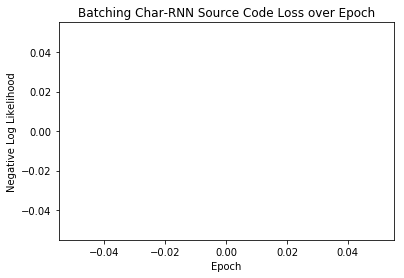

In [20]:
plt.figure()
plt.title("Batching Char-RNN Source Code Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood")
plt.plot(train_epoch_losses)

## Using User Specified Input

Let's test this ourselves by supplying our own Python source code.

In [21]:
def evaluate(seq_tensor, hidden = char_rnn.init_hidden()):
    """Return an output character tensor, given an input character sequence tensor."""
    batch_seq_size, _, _ = seq_tensor.size()
    
    for i in range(0, batch_seq_size):
        x_char_tensor = seq_tensor.narrow(0, i, 1)
        output, hidden = char_rnn(x_char_tensor, hidden)
    return output, hidden

def predict(input_char_seq, max_len=10, max_window_size=None):
    print("".join(input_char_seq))
    print("~~~~~Auto Completion~~~~~")
    with torch.no_grad():
        print("".join(input_char_seq), end="")
        seq_tensor = charseq_to_tensor(input_char_seq)
        # expand the batch_size dimension to match char_rnn model
        output, hidden = evaluate(seq_tensor.expand(-1, char_rnn.batch_size, -1))

        for i in range(max_len):
            # Suggestion: Maybe probabalistically choose using weights over all choices?
            next_char = readable_from_output(output)[0][0]
            if next_char == FILE_END:
                return
            print(next_char, end="")
            input_char_seq = input_char_seq + (next_char, )
            if max_window_size is not None:
                window_size = max_window_size
            else:
                window_size = len(input_char_seq)
            seq_tensor = charseq_to_tensor(input_char_seq[-window_size:])
            output, hidden = evaluate(seq_tensor.expand(-1, char_rnn.batch_size, -1))
        print("\n~~~~~max_len reached~~~~~")

# this is symbolic, to demonstrate that we have memorized the training data.
CODE = (FILE_START,)
predict(tuple(CODE))



~~~~~Auto Completion~~~~~
bbbbbbbbbb
~~~~~max_len reached~~~~~
